# Part 1

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Get the data 
df = pd.read_csv("football.csv", sep=";")
df = df.dropna()
display(df.columns)

X = df.drop(columns="GoalsScored")
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = df["GoalsScored"]

Index(['X_ScoreRateH', 'X_ScoreRateA', 'X_ConcedeRateH', 'X_ConcedeRateA',
       'X_CornerRatioH', 'X_CornerRatioA', 'X_FoulRatioH', 'X_FoulRatioA',
       'GoalsScored'],
      dtype='object')

In [ ]:
import pymc as pm

# Modeling 
with pm.Model() as model:
    beta = pm.Normal("beta", mu = 0, sigma = 5, shape = X.shape[1])
    
    intercept = pm.Normal("intercept", mu=0, sigma=5)

    # Link function?
    mu = pm.math.exp(intercept + pm.math.dot(X, beta))

    y_obs = pm.Poisson("y_obs", mu=mu, observed = y)

    trace = pm.sample(1000,chains=4, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.999,0.014,0.971,1.025,0.0,0.0,7093.0,3237.0,1.0
beta[0],0.083,0.017,0.052,0.114,0.0,0.0,5812.0,3206.0,1.0
beta[1],0.033,0.018,-0.000,0.065,0.0,0.0,4984.0,3191.0,1.0
beta[2],-0.049,0.017,-0.084,-0.019,0.0,0.0,6413.0,3178.0,1.0
beta[3],0.011,0.016,-0.019,0.040,0.0,0.0,5686.0,3163.0,1.0
beta[4],0.015,0.017,-0.018,0.046,0.0,0.0,5545.0,2929.0,1.0
beta[5],0.000,0.017,-0.030,0.033,0.0,0.0,5482.0,2750.0,1.0
beta[6],-0.052,0.016,-0.081,-0.022,0.0,0.0,6295.0,3270.0,1.0
beta[7],-0.019,0.016,-0.048,0.010,0.0,0.0,6201.0,3428.0,1.0


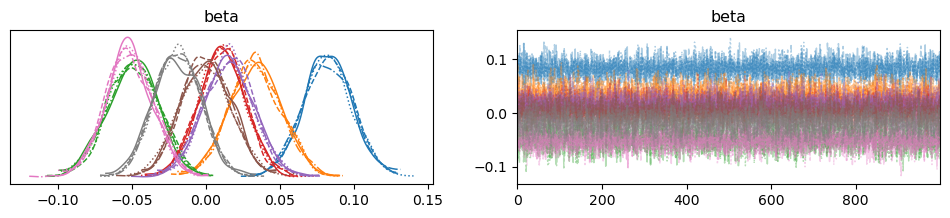

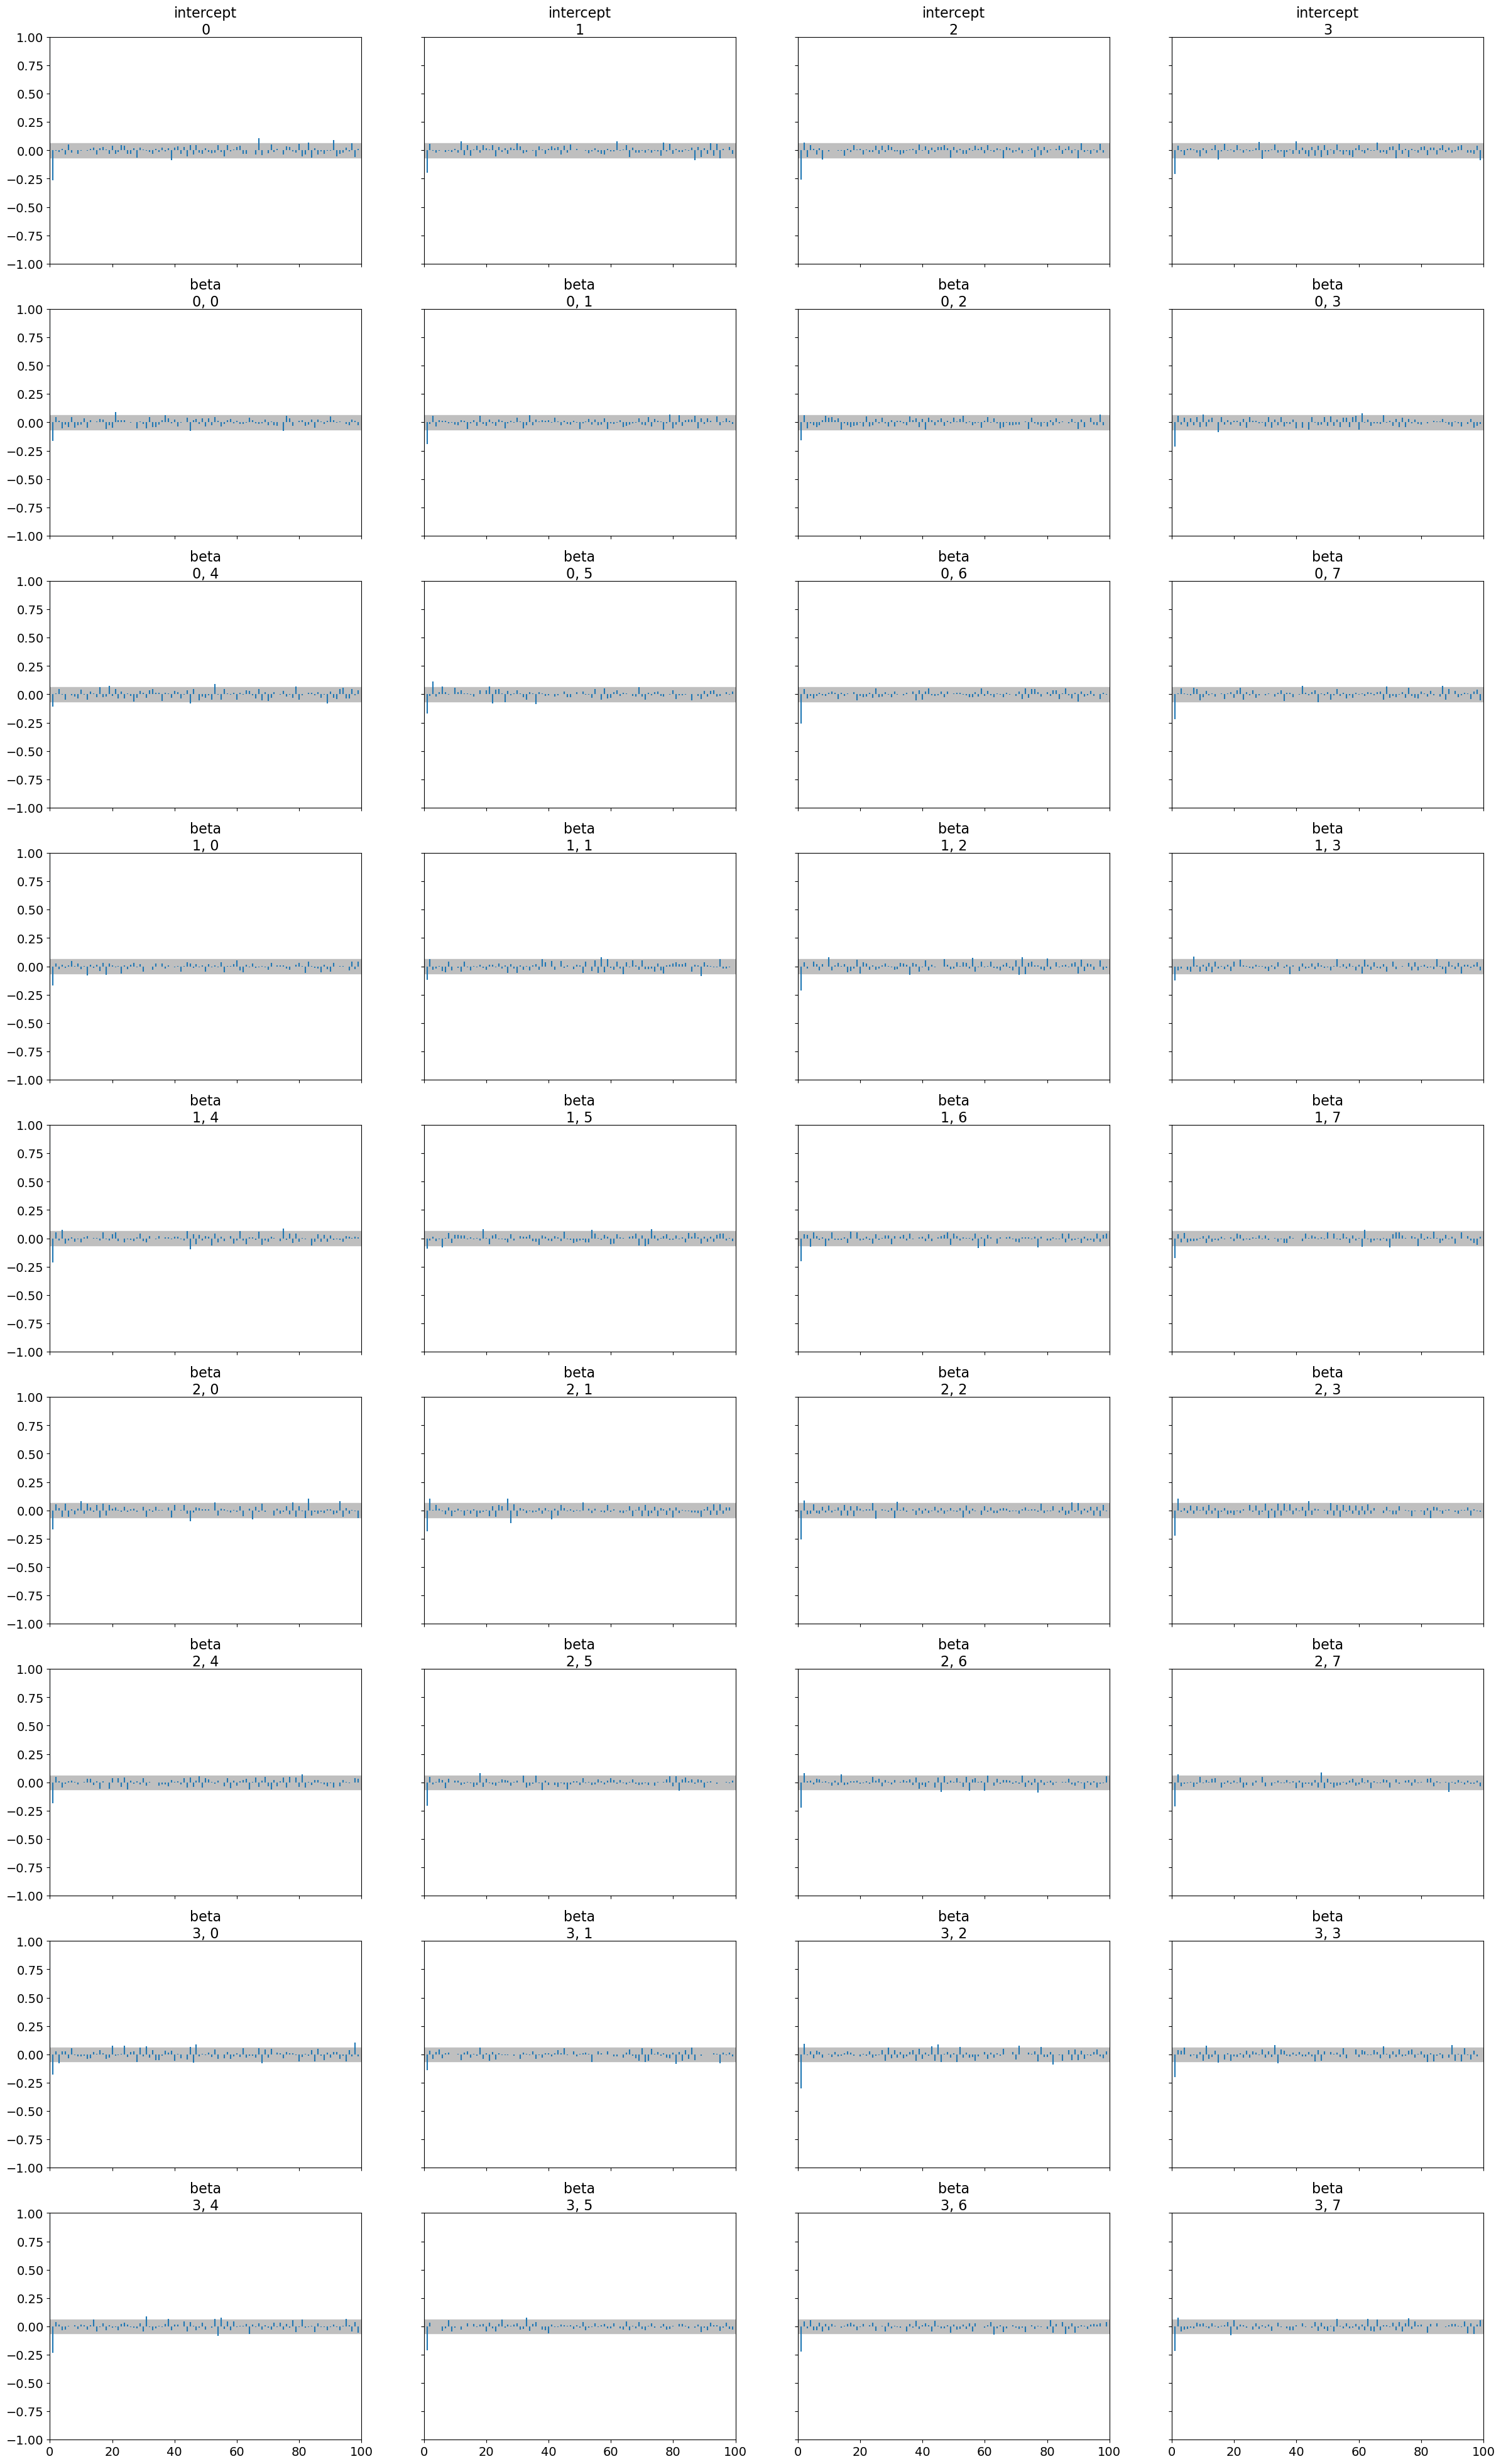

In [4]:
import arviz as az

# Diagnostic plots
az.plot_trace(trace, var_names=["beta"])
az.plot_autocorr(trace, var_names=["intercept", "beta"])

# summary, more disagnostics
az.summary(trace, var_names=["intercept", "beta"]) 